In [2]:
from functions import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [ ]:
# Clean Data (stopwords, functions from .py)

df = pd.read_pickle("df_24.pkl")

df["text_proc"] = df["Text"].progress_apply(text_process_ours)

# Feature engineering

In [3]:
# read clean data
df = pd.read_pickle("df_24_processed.pkl")

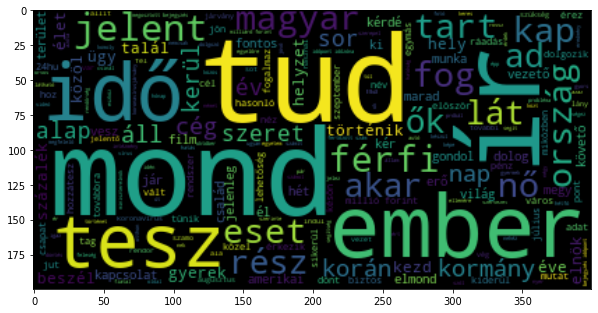

In [4]:
a = " ".join(df["text_proc"].values)

fig, ax = plt.subplots(figsize=(10, 8))

wordcloud = WordCloud().generate(a)
plt.imshow(wordcloud, interpolation='bilinear')

In [8]:
number_of_authors = 6
top_author = df["Author"].value_counts().iloc[1 : number_of_authors + 1].index
top_author

df_top = df.loc[df["Author"].isin(top_author)].reset_index(drop=True)

labelencoder = LabelEncoder()
df_top['Author_labeled'] = labelencoder.fit_transform(df_top["Author"])

In [9]:
df["tokens"] = df["text_proc"].apply(str.split).apply(lambda sentence: convert(sentence))

In [10]:
dictionary_LDA = corpora.Dictionary(df['tokens'].tolist())
dictionary_LDA.filter_extremes(no_below=3, no_above = 0.6)

In [11]:
corpus = [dictionary_LDA.doc2bow(tok) for tok in df['tokens'].tolist()]

In [12]:
np.random.seed(123)
num_topics = 15
lda_model = models.LdaModel(
    corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4
)

In [13]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)

# output a mappában lda_out.html

In [14]:
topics = [lda_model[corpus[i]] for i in range(len(df))]

In [15]:
document_topic = (
    pd.concat(
        [
            topics_document_to_dataframe(topics_document, num_topics=num_topics)
            for topics_document in topics
        ]
    )
    .reset_index(drop=True)
    .fillna(0)
)

In [16]:
df['topic'] = document_topic.idxmax(axis=1)

In [17]:
df["word_count"] = df["tokens"].apply(len)

In [18]:
number_of_authors = 6
top_author = df["Author"].value_counts().iloc[1 : number_of_authors + 1].index
top_author

df_top = df.loc[df["Author"].isin(top_author)].reset_index(drop=True)

labelencoder = LabelEncoder()
df_top['Author_labeled'] = labelencoder.fit_transform(df_top["Author"])

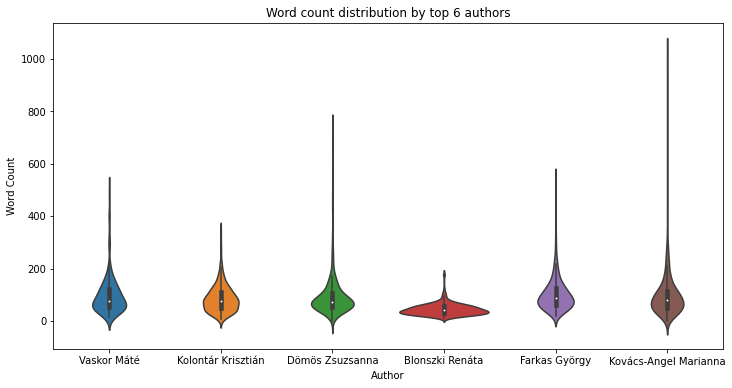

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(x="Author", y="word_count", data=df_top, ax=axes)
plt.xlabel("Author")
plt.ylabel("Word Count")
plt.title("Word count distribution by top 6 authors")
plt.show()

In [21]:
# train test split in time (80-20)

In [22]:
train_dates = df_top["Date"].unique()[: int(df_top["Date"].nunique() * 0.8)]

In [23]:
X_train = df_top.loc[df_top["Date"].isin(train_dates),"text_proc"]
X_test = df_top.loc[~df_top["Date"].isin(train_dates),"text_proc"]

In [24]:
y_train = df_top.loc[df_top["Date"].isin(train_dates),"Author_labeled"]
y_test = df_top.loc[~df_top["Date"].isin(train_dates),"Author_labeled"].reset_index(drop=True)

In [25]:
# a kommentelt modelleket mind kipróbáltuk,
# de teljes faszságot produkáltak a szerző nélküli cikkeket, egyedül a multinomialNB működött

vectorizer = "Tfidf Vectorizer"

estimators = [
    # "Logistic Regression",
    # "One vs Rest",
    # "Random Forest",
    # "Support Vector Classifier",
    "Multinomial Naive Bayes",
    # "XGBoost Classifier",
]

pipelines, vec = build_model(vectorizer, estimators, X_train, y_train)

train Multinomial Naive Bayes


In [26]:
get_f_score(pipelines,X_train, y_train,X_test, y_test)

,test,train
Multinomial Naive Bayes,0.733668,0.982747


In [27]:
# getting the predictions of the Validation Set...
predictions = pipelines[0]["pipeline"].predict(X_test)
# getting the Precision, Recall, F1-Score
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       0.99      0.97      0.98        71
           2       0.60      0.60      0.60        83
           3       0.73      0.96      0.83        49
           4       0.69      0.45      0.55        80
           5       0.46      0.56      0.50        57

    accuracy                           0.73       398
   macro avg       0.74      0.76      0.74       398
weighted avg       0.74      0.73      0.73       398



In [28]:
names = df_top.drop_duplicates(subset=["Author"])[["Author", "Author_labeled"]].sort_values(
    by="Author_labeled"
)["Author"].values

Normalized confusion matrix


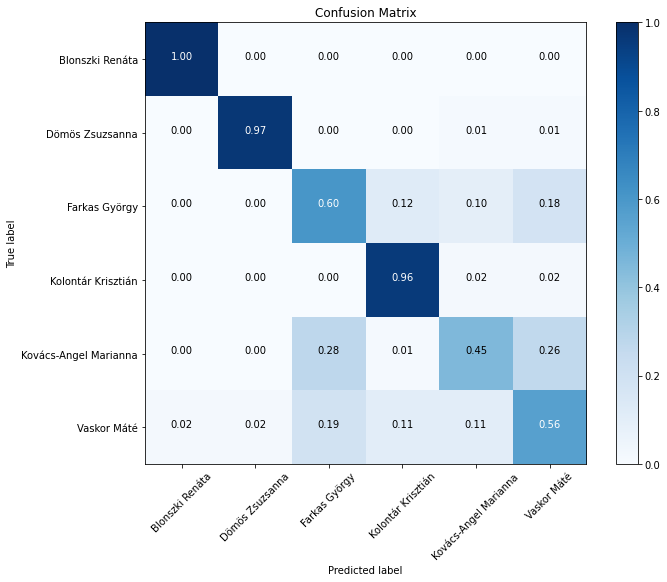

In [29]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(cm, classes=names, normalize=True, title="Confusion Matrix")

___

## Predict authors in articles without author

In [30]:
df["len"] = df["Text"].apply(len)
df["mti"] = df.loc[df["Author"] == "24.hu", "Text"].apply(
    lambda x: np.where("MTI" in x, 1, 0)
)

# filter MTI statements
x_pred = df.loc[(df["mti"] == 0) & (df["Author"] == "24.hu"),"text_proc"].reset_index(drop=True)

In [31]:
y_pred = {}
y_pred["Multinomial Naive Bayes"] = pipelines[0]["pipeline"].predict_proba(x_pred)

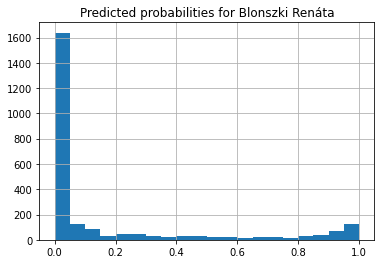

In [32]:
author_names = (
    df_top.drop_duplicates(subset=["Author"])[["Author", "Author_labeled"]]
    .sort_values(by="Author_labeled")
    .set_index("Author_labeled")
    .to_dict()
)

Author_pred = pd.DataFrame(y_pred["Multinomial Naive Bayes"]).rename(
    author_names["Author"], axis=1
)

Author_pred["Blonszki Renáta"].round(2).hist(bins=20)
plt.title("Predicted probabilities for Blonszki Renáta")
plt.show()

In [33]:
# we only marked those classifications successfull, that got >90% probability. <90% were marked as "other"
pred = pd.DataFrame(y_pred["Multinomial Naive Bayes"]).assign(
    pred_class=[
        np.argmax(p) if max(p) > 0.9 else 6 for p in y_pred["Multinomial Naive Bayes"]
    ]
)

In [34]:
final_pred = df.loc[
    (df["mti"] == 0) & (df["Author"] == "24.hu")
].reset_index().assign(pred=pred["pred_class"]).drop(columns="index").merge(
    df_top.drop_duplicates("Author")[["Author", "Author_labeled"]],
    left_on="pred",
    right_on="Author_labeled",
    how="left",
).fillna("other").reset_index(
    drop=True
)[
    ["Date", "Link", "Text", "rovat", "Author_y"]
].rename(
    columns={"Author_y": "Predicted_author"}
)

In [35]:
final_pred["Predicted_author"].value_counts()

other                    1834
Blonszki Renáta           187
Kolontár Krisztián        121
Kovács-Angel Marianna      98
Vaskor Máté                73
Farkas György              71
Dömös Zsuzsanna            66
Name: Predicted_author, dtype: int64

In [36]:
final_pred.groupby(["Predicted_author", "rovat"])["Link"].count().reset_index().query(
    "Link > 10 and Predicted_author != 'other' "
).sort_values(by=["Predicted_author","Link"],ascending=False)

,Predicted_author,rovat,Link
43,Vaskor Máté,kulfold,47
39,Vaskor Máté,belfold,16
32,Kovács-Angel Marianna,belfold,36
33,Kovács-Angel Marianna,fn,31
37,Kovács-Angel Marianna,otthon,16
24,Kolontár Krisztián,belfold,67
25,Kolontár Krisztián,elet-stilus,24
28,Kolontár Krisztián,kulfold,16
17,Farkas György,belfold,22
20,Farkas György,kulfold,17


In [37]:
df_top.groupby(["Author", "rovat"])["Link"].count().reset_index().query(
    "Link > 10"
).sort_values(by=["Author", "Link"], ascending=False)

,Author,rovat,Link
25,Vaskor Máté,kulfold,151
22,Vaskor Máté,belfold,102
23,Vaskor Máté,fn,20
15,Kovács-Angel Marianna,belfold,121
18,Kovács-Angel Marianna,kulfold,91
16,Kovács-Angel Marianna,fn,63
17,Kovács-Angel Marianna,kozelet,42
12,Kolontár Krisztián,belfold,315
9,Farkas György,kulfold,166
6,Farkas György,belfold,139


___

# Different  site classification

# DataCleaning and preparation 

df_pages=pd.read_csv("jun-jul-aug.csv")

pages=['444', 'HVG', '888', 'Origo', 'Napi.hu','24.hu']

df_top_pages = df_pages.loc[df_pages["Page"].isin(pages)].reset_index(drop=True)

df_top_pages["Text"]=df_top_pages["Text"].astype(str)

df_top_pages["Text_len"]=df_top_pages["Text"].apply(len)

df_filtered=pd.DataFrame()
for page in pages:
    sub_df=df_top_pages[df_top_pages["Page"]==page]
    df_filtered=df_filtered.append(sub_df.sort_values(by=["Text_len"], ascending=False)[:300],ignore_index=True)

df_filtered['Text_len'].hist(bins=100)

print("legrövidebb cikk : " +str(df_filtered['Text_len'].min()))
print("leghosszabb cikk : " +str(df_filtered['Text_len'].max()))


df_filtered["text_proc"] = df_filtered["Text"].progress_apply(text_process_ours)

df_filtered.to_pickle("df_filtered_processed_correct.pkl")

In [2]:
df_filtered=pd.read_pickle("df_filtered_processed_correct.pkl").query("Page != 'Napi.hu'")

In [3]:
df_filtered.head()

,Unnamed: 0,Date,Link,Links,Page,Text,Title,Author,Text_len,text_proc
0,10052,2020-07-14,https://444.hu/2020/07/14/a-magyar-tortenelem-...,['https://www.kormany.hu/hu/nemzeti-konzultaci...,444,"Vannak, akik szerint a Nemzeti Együttműködés R...",A magyar történelem kilenc legjobb nemzeti kon...,Bede Márton,20287,szellemi teljesítmény alkotmánymódosítás mond ...
1,23588,2020-08-14,https://444.hu/2020/08/14/vannak-akiknek-event...,['https://444.hu/2019/07/07/en-nem-vagyok-lmbt...,444,Az elmúlt évekre a Pride már egy egész hónapon...,"Vannak, akiknek évente ez az egyetlen nap, ami...",Horváth Bence,20038,elmúlt év hónap tartó program mag foglaló esem...
2,2376,2020-06-27,https://444.hu/2020/06/27/a-jarvany-megmutatta...,"['https://444.hu/tag/kucsera-csaba', 'https://...",444,"A koronavírus-járvány megmutatta, hogy mennyir...","A járvány megmutatta, hogy nagyon elnagyolt fo...",Horváth Bence,18908,koronavírusjárvány megmutat mennyire tud kezd ...
3,23028,2020-08-13,https://444.hu/2020/08/13/peterfalvi-attila-ez...,['https://444.hu/2020/08/01/a-facebookra-irt-k...,444,"Tud arról, hogy az Igazságügyi Minisztériumban...",Péterfalvi Attila: Ez nem Facebook-törvény,Sarkadi Zsolt,17056,tud esetleg megindul közösségi média kapcsolat...
4,21897,2020-08-11,https://444.hu/2020/08/11/nincs-olyan-hogy-csa...,['https://24.hu/fn/uzleti-tippek/2006/11/07/ki...,444,"Politikai rovatvezetőként egyike vagy azoknak,...","„Nincs olyan, hogy csak kicsit szólnak bele az...",Rényi Pál Dániel,16997,politikai rovatvezető tölt felmondási idő zajl...


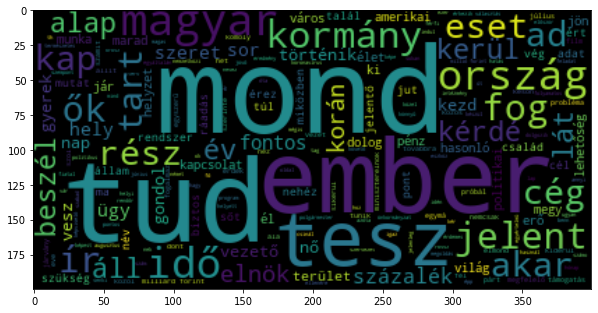

In [4]:
a = " ".join(df_filtered["text_proc"].values)

fig, ax = plt.subplots(figsize=(10, 8))

wordcloud = WordCloud().generate(a)
plt.imshow(wordcloud, interpolation='bilinear')

In [5]:
# The dataprocessing is working pretty well on other pages as well 

In [6]:
#Label encoding
labelencoder = LabelEncoder()
df_filtered['Page_labeled'] = labelencoder.fit_transform(df_filtered["Page"])

In [7]:
#Encoded pages and the codes

In [8]:
df_filtered.drop_duplicates("Page")[["Page", "Page_labeled"]]

,Page,Page_labeled
0,444,1
300,HVG,3
600,888,2
900,Origo,4
1500,24.hu,0


In [9]:
#Filtering outliers from the sample, y lenght

In [10]:
df_filtered=df_filtered[df_filtered["Text_len"]<30000]

In [11]:
#List for labels 

In [12]:
thick_list=list(df_filtered.drop_duplicates("Page")[["Page", "Page_labeled"]]["Page"])

In [13]:
#Train test plit 

In [14]:
X_train, X_test, y_train, y_test = train_test_split( df_filtered[['text_proc', "Text_len"]], df_filtered['Page_labeled'], test_size=0.2, random_state=69)

In [15]:
# We will use article lenght later

Text(0.5, 0, 'Page')

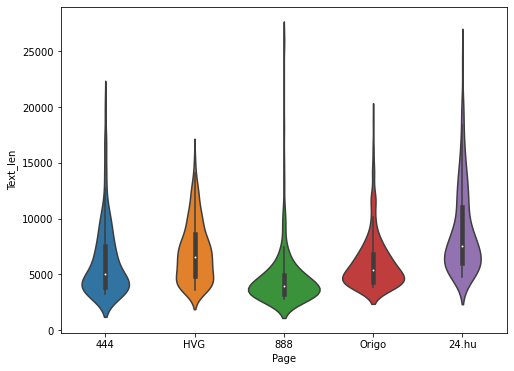

In [16]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.violinplot(x="Page", y="Text_len", data=df_filtered, ax=axes)
plt.xlabel("Page")

In [17]:
#The test set in  balanced, therefor the train as well 

<AxesSubplot:>

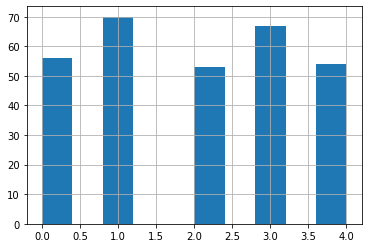

In [18]:
y_test.hist()

In [19]:
# Addig the lenght of the actircles to the vectorized texts

In [20]:
Text_len_train=X_train["Text_len"].to_numpy()
X_train.drop(["Text_len"], axis=1, inplace=True)
Text_len_test=X_test["Text_len"].to_numpy()
X_test.drop(["Text_len"], axis=1, inplace=True)

In [37]:
vec = TfidfVectorizer()
vec.fit(X_train["text_proc"])

TfidfVectorizer()

In [38]:
X_train_vec=vec.transform(X_train["text_proc"])

In [39]:
X_test_vec=vec.transform(X_test["text_proc"])

In [40]:
trial=X_train_vec
Text_len_train.shape = [Text_len_train.shape[0],1] 

X_train_new=np.concatenate([trial.toarray(), Text_len_train], axis=1)

trial_2=X_test_vec


Text_len_test.shape
Text_len_test.shape = [Text_len_test.shape[0],1] 

X_test_new=np.concatenate([trial_2.toarray(), Text_len_test], axis=1)

#### Hyperparameter opt

In [41]:
param_hyperopt = {
    "alpha": hp.uniform("alpha", 0.0, 1.0),
}

In [44]:
num_eval =30

In [45]:
results_hyperopt = hyperopt(param_hyperopt, X_train_new, y_train, X_test_new, y_test, num_eval)


100%|██████████| 30/30 [00:11<00:00,  2.71trial/s, best loss: -0.991668220346744] 

##### Results
Score best parameters:  0.06707595420202904
Best parameters:  {'alpha': 0.0009143429771466096}
Test Score:  0.5333333333333333
Time elapsed:  11.325892925262451
Parameter combinations evaluated:  30


In [30]:
#Train set

In [46]:
NB_modell =  MultinomialNB(alpha=0.0009143429771466096)
score =f1_score(y_train, NB_modell.fit(X_train_new, y_train).predict(X_train_new), average="weighted")
score

0.991668220346744

In [47]:
NB_modell =  MultinomialNB(alpha=0.0009143429771466096)
score =f1_score(y_test, NB_modell.fit(X_train_new, y_train).predict(X_test_new), average="weighted")
score

0.5382009715824093

In [48]:
# Here we face overfitting as well , kinda sad 

In [49]:
predictions=NB_modell.fit(X_train_new, y_train).predict(X_test_new)

In [50]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.39      0.71      0.51        56
           1       0.85      0.47      0.61        70
           2       0.64      0.53      0.58        53
           3       0.47      0.57      0.52        67
           4       0.60      0.39      0.47        54

    accuracy                           0.53       300
   macro avg       0.59      0.53      0.54       300
weighted avg       0.60      0.53      0.54       300



Normalized confusion matrix


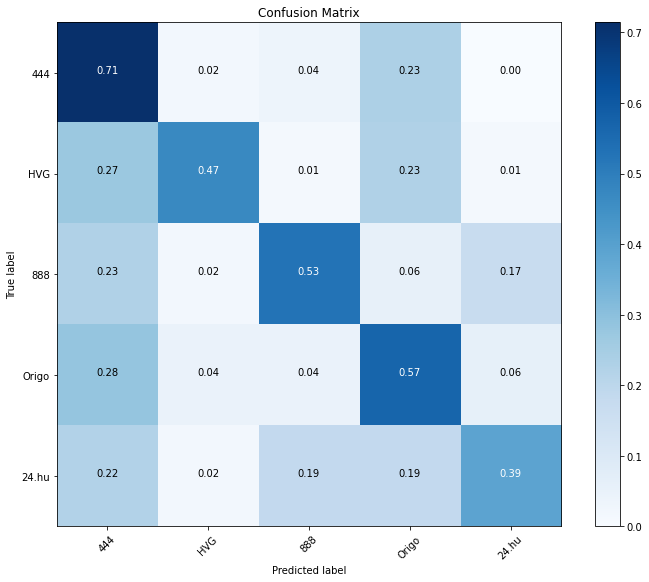

In [51]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(cm, classes=thick_list, normalize=True, title="Confusion Matrix")